<a href="https://colab.research.google.com/github/BDonadelli/Codigos-em-financas/blob/main/Bollinger.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


ESTRATÉGIA
1. fechou fora-fechou dentro com o ultimo fechamento 3 tr da sma20, entra no rompimento de máxima / mínima do ultimo dia
2. stop no fundo/topo do ff-fd, saída se chegar na media 20 dos fechamentos



In [2]:
import pandas as pd
import numpy as np
import copy
import datetime
import yfinance as yf
import os

In [3]:
def reset_data() :
  data=pd.read_csv(os.getcwd()+'/data/data.csv')
  data.set_index(data['Date'],inplace=True)
  data.drop(columns=['Date'],axis=1,inplace=True)
 

In [36]:
codigo = str(input('codigo ='))
periodo='max'

In [37]:
data = pd.DataFrame()
data = yf.download(tickers=codigo+'.SA' , period=periodo , progress = False  , auto_adjust=True)

In [38]:
import talib 

data['u_bb'], data['bb_m'], data['l_bb'] = talib.BBANDS(data['Close'], timeperiod = 20)
data['atr'] = talib.ATR(high=data['High'],close=data['Close'],low=data['Low'], timeperiod=20)

In [39]:
data

Open       High        Low      Close       Volume  \
Date                                                                  
2000-01-03   1.450586   1.450586   1.450586   1.450586  35389440000   
2000-01-04   1.370341   1.370341   1.370341   1.370341  28861440000   
2000-01-05   1.356514   1.356514   1.356514   1.356514  43033600000   
2000-01-06   1.351823   1.351823   1.351823   1.351823  34055680000   
2000-01-07   1.357995   1.357995   1.357995   1.357995  20912640000   
...               ...        ...        ...        ...          ...   
2024-01-22  37.500000  37.810001  37.230000  37.700001     22753700   
2024-01-23  37.840000  38.369999  37.430000  38.169998     32498500   
2024-01-24  38.290001  38.540001  37.770000  37.880001     25415300   
2024-01-25  38.259998  39.279999  38.130001  39.279999     48655300   
2024-01-26  39.099998  40.090000  38.910000  39.959999     41378200   

                 u_bb     bb_m       l_bb       atr  
Date                                                 
2000-01-03        NaN      NaN        NaN       NaN  
2000-01-04        NaN      NaN        NaN       NaN  
2000-01-05        NaN      NaN        NaN       NaN  
2000-01-06        NaN      NaN        NaN       NaN  
2000-01-07        NaN      NaN        NaN       NaN  
...               ...      ...        ...       ...  
2024-01-22  39.135595  37.8595  36.583405  0.714167  
2024-01-23  39.036677  37.9485  36.860323  0.725458  
2024-01-24  38.943572  38.0055  37.067428  0.727686  
2024-01-25  39.140094  38.1030  37.065906  0.761301  
2024-01-26  39.492858  38.2330  36.973141  0.782236  

[6045 rows x 9 columns]

In [40]:
data.dropna(inplace=True)
data.to_csv(os.getcwd()+'/data/data.csv')

### entrada

In [41]:
desvio = 2.95 # atrs

# Compra
signalB = np.where((data['Close'].shift(2) < data['l_bb'].shift(2))        #anteontem fechou fora
                  & (data['Close'].shift(1) > data['l_bb'].shift(1))       #ontem fechou dentro
                  & (np.abs(data['Close'] - data['bb_m']) > desvio*data['atr']) # e fechou longe da média
                  & (data['Close'] >= np.maximum(data['Close'].shift(1),data['Close'].shift(2)) ) # hoje rompeu as maximas
                  , 1, 0)
# Venda descoberta
signalS = np.where((data['Close'].shift(2) > data['u_bb'].shift(2))          #anteontem fechou fora
                  & (data['Close'].shift(1) < data['u_bb'].shift(1))         #ontem fechou dentro
                  & (np.abs(data['Close'] - data['bb_m']) > desvio*data['atr'])   # e fechou longe da média
                  & (data['Close'] <= np.minimum(data['Close'].shift(1),data['Close'].shift(2)) ) # hoje rompeu as minimas
                  , -1, 0)
data['signal'] = signalB + signalS

In [42]:
aux = data[(data['signal']== 1) | (data['signal']== -1)].copy()

### saída

In [43]:
m=len(data)

i=0
while (i < m -1) :
    while (i < m -1 and data['signal'].iloc[i] == 0) : i+=1
    j=i
    if data['signal'].iloc[j] == 1 :
        while (j < m-1 and data['Close'].iloc[j] < data['bb_m'].iloc[j]  ) : j+=1
    else:
        while (j < m-1 and data['Close'].iloc[j] > data['bb_m'].iloc[j]  ) : j+=1
    # data.iloc[i:j,'signal'] = data['signal'].iloc[i]
    data.loc[data.index[i]:data.index[j],'signal'] = data['signal'].iloc[i]

    i=j+1



In [44]:
data

Open       High        Low      Close       Volume  \
Date                                                                  
2000-01-31   1.259479   1.259479   1.259479   1.259479  32266240000   
2000-02-01   1.283923   1.283923   1.283923   1.283923  23672320000   
2000-02-02   1.308614   1.308614   1.308614   1.308614  14272000000   
2000-02-03   1.345650   1.345650   1.345650   1.345650  25950720000   
2000-02-04   1.379723   1.379723   1.379723   1.379723  21199360000   
...               ...        ...        ...        ...          ...   
2024-01-22  37.500000  37.810001  37.230000  37.700001     22753700   
2024-01-23  37.840000  38.369999  37.430000  38.169998     32498500   
2024-01-24  38.290001  38.540001  37.770000  37.880001     25415300   
2024-01-25  38.259998  39.279999  38.130001  39.279999     48655300   
2024-01-26  39.099998  40.090000  38.910000  39.959999     41378200   

                 u_bb       bb_m       l_bb       atr  signal  
Date                                                           
2000-01-31   1.391795   1.319503   1.247210  0.017160       0  
2000-02-01   1.385095   1.315182   1.245269  0.017524       0  
2000-02-02   1.380106   1.312787   1.245468  0.017883       0  
2000-02-03   1.379131   1.312478   1.245825  0.018840       0  
2000-02-04   1.383764   1.313565   1.243365  0.019602       0  
...               ...        ...        ...       ...     ...  
2024-01-22  39.135595  37.859500  36.583405  0.714167       0  
2024-01-23  39.036677  37.948500  36.860323  0.725458       0  
2024-01-24  38.943572  38.005500  37.067428  0.727686       0  
2024-01-25  39.140094  38.103000  37.065906  0.761301       0  
2024-01-26  39.492858  38.233000  36.973141  0.782236       0  

[6025 rows x 10 columns]

In [70]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(rows=3, cols=1) #go.Figure()
fig.add_trace(go.Scatter(x = data.index , y = data['Close'].values , name="preço"),1,1)
fig.add_trace(go.Scatter(x = data.index , y = data['u_bb'].values, mode='lines', 
                         line=dict(color='firebrick', width=2, dash='dash'), name="mms20"),1,1)
fig.add_trace(go.Scatter(x = data.index , y = data['l_bb'].values, mode='lines', 
                         line=dict(color='gray', width=2, dash='dash'), name="upper bb"),1,1)
fig.add_trace(go.Scatter(x = data.index , y = data['bb_m'].values, mode='lines', 
                         line=dict(color='gray', width=2, dash='dash'), name="lower bb"),1,1)
fig.add_trace(go.Scatter(x = aux.index, y = data['Close'] , mode='markers' ,name='sinal',
                             marker=dict(size=12, symbol="arrow", angle=45, line=dict(width=2, color="DarkSlateGrey"))
                         ),1,1)
fig.update_traces(
    marker=dict(size=12, symbol="arrow", angle=45, line=dict(width=2, color="DarkSlateGrey")),
    selector=dict(mode="markers"),
)
# fig.add_trace(go.Scatter(x = df.loc[sai].index, y = df.loc[sai]['Close '+ativo] , mode='markers' ,name='Saida',
#                          marker=dict(size=12, symbol="arrow", angle=-135, line=dict(width=2, color="red"))
#                          ),1,1)
fig.add_trace(go.Scatter(x = data.index , y = data['signal'].values , name="sinal"),2,1)


fig.add_trace(go.Scatter(x =data.index , y = data['atr'].values*desvio , mode='lines', name=f"{desvio}*ATR"),3,1)


fig.show()

In [60]:
data['retrn'] =  np.log(data['Close']) - np.log(data['Close'].shift(1))
data['strategy_returns'] = data['retrn'] * (data['signal'].shift(1))

In [61]:
print(f"Strategy returns: {data['strategy_returns'].cumsum().iloc[-1]}")


Strategy returns: 0.0876991952102893


In [62]:
print("Buy and hold returns:",data['retrn'].cumsum().iloc[-1])


Buy and hold returns: 3.4571805617632667


In [67]:
df = data.copy()
df["Date"]=df.index

# feriados

inicio = df.index[0].strftime("%Y-%m-%d")
fim = df.index[-1].strftime("%Y-%m-%d")

url = 'https://raw.githubusercontent.com/BDonadelli/Codigos-em-financas/main/data/feriados.csv'

feriado = pd.read_csv(url)
feriado['Data'] =  pd.to_datetime(feriado['Data'], format='%d/%m/%Y')
feriado.set_index(feriado.Data, inplace=True)
feriado['Data'] = feriado['Data'].astype(str)
lista = feriado.Data.loc[inicio:fim].values

# feriados

import plotly.io as pio
pio.renderers.default = 'vscode'


fig = make_subplots(rows=3, cols=1,
                          #shared_xaxes=True,
                          vertical_spacing=0.05,
                          subplot_titles=(codigo, 'sinal C/V', 'ATR'),
                          row_width=[0.1, 0.2, 0.4])

fig.append_trace({ 'x': df.Date,
           'open': df.Open,
           'close': df.Close,
           'high': df.High,
           'low': df.Low,
           'type': 'candlestick',
           'name': codigo,
           'showlegend': True }
, row=1, col=1 )

fig.append_trace(go.Scatter( name="sma20",
                 line=dict(color='lightblue'),
    x=df.index,
    y=df.bb_m,
), row=1, col=1)

fig.append_trace(go.Scatter( name="sma20 + 2dp",
                 line=dict(color='lightgreen'),
    x=df.index,
    y=df.u_bb,
), row=1, col=1 )

fig.append_trace(go.Scatter( name="sma20 - 2dp",
                 line=dict(color='lightgreen'),
    x=df.index,
    y=df.l_bb,
), row=1, col=1)

fig.append_trace(go.Scatter(x = data.index , y = data['signal'].values , name="sinal"),2,1)
fig.update_traces(
    marker=dict(size=12, symbol="arrow", angle=45, line=dict(width=2, color="DarkSlateGrey")),
    selector=dict(mode="markers"),)

fig.append_trace(go.Scatter( name="sinal C/V",
    x = df.Date,
    y = df.atr,
), row=3, col=1)

fig.append_trace(go.Scatter( name="sinal C/V",
    x = df.Date,
    y = df.signal,
), row=2, col=1)

fig.update_xaxes(
        rangeslider_visible=False,
        rangebreaks=[
            # NOTE: Below values are bound (not single values), ie. hide x to y
            dict(bounds=["sat", "mon"]),  # hide weekends, eg. hide sat to before mon
            #dict(bounds=[16, 9.5], pattern="hour"),  # hide hours outside of 9.30am-4pm
            dict(values=lista)#["2018-12-24","2019-12-24", "2020-12-24", "2021-12-24", "2022-12-24"]) ,
            #dict(values=["2018-12-25","2019-12-25", "2020-12-25", "2021-12-24", "2022-12-24"]) ,
            #dict(values=["2018-01-01","2019-01-01", "2020-01-01", "2021-01-01", "2022-01-01"])
        ]
    )

fig.update_layout(height=900, width=1200)

fig.show()


In [76]:
data[['retrn','strategy_returns']].cumsum().iplot()


In [85]:
import quantstats as qs

help(qs.reports.full)

Help on function full in module quantstats.reports:

full(returns, benchmark=None, rf=0.0, grayscale=False, figsize=(8, 5), display=True, compounded=True, periods_per_year=252, match_dates=True, **kwargs)



                           Strategy
-------------------------  ----------
Start Period               2000-02-01
End Period                 2024-01-26
Risk-Free Rate             0.0%
Time in Market             4.0%

Cumulative Return          -0.23%
CAGR﹪                     -0.01%

Sharpe                     0.04
Prob. Sharpe Ratio         58.19%
Smart Sharpe               0.04
Sortino                    0.06
Smart Sortino              0.06
Sortino/√2                 0.04
Smart Sortino/√2           0.04
Omega                      1.03

Max Drawdown               -24.8%
Longest DD Days            3319
Volatility (ann.)          8.67%
Calmar                     -0.0
Skew                       -0.22
Kurtosis                   74.94

Expected Daily %           -0.0%
Expected Monthly %         -0.0%
Expected Yearly %          -0.01%
Kelly Criterion            1.63%
Risk of Ruin               0.0%
Daily Value-at-Risk        -0.9%
Expected Shortfall (cVaR)  -0.9%

Max Consecutive Wins       5

None

Start      Valley         End  Days  Max Drawdown  99% Max Drawdown
1  2014-12-26  2015-01-06  2024-01-26  3319    -24.804247        -16.420149
2  2014-04-16  2014-05-07  2014-12-22   251    -17.988114        -16.444948
3  2000-03-15  2000-07-04  2000-12-13   274    -14.180195        -12.053584
4  2008-07-31  2008-08-18  2011-08-31  1127    -13.595019         -8.725455
5  2011-09-02  2013-07-08  2014-04-14   956     -9.704031         -5.286709

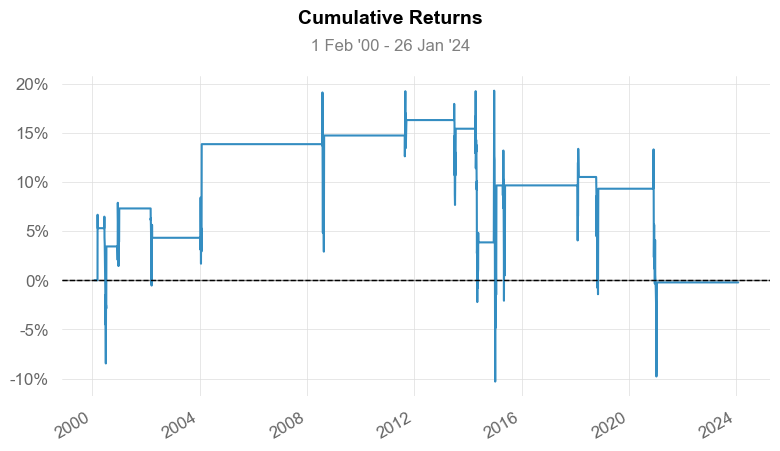

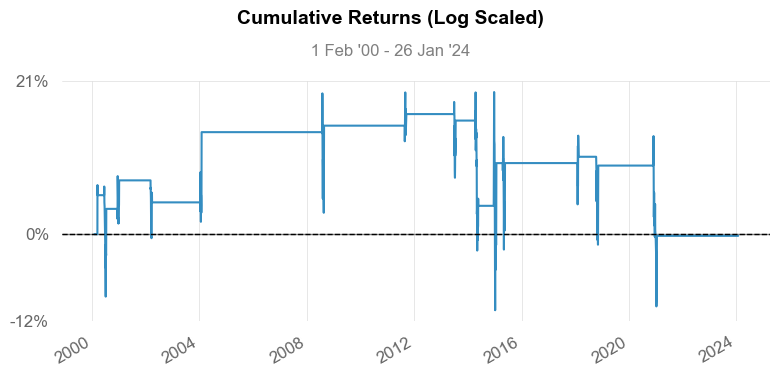

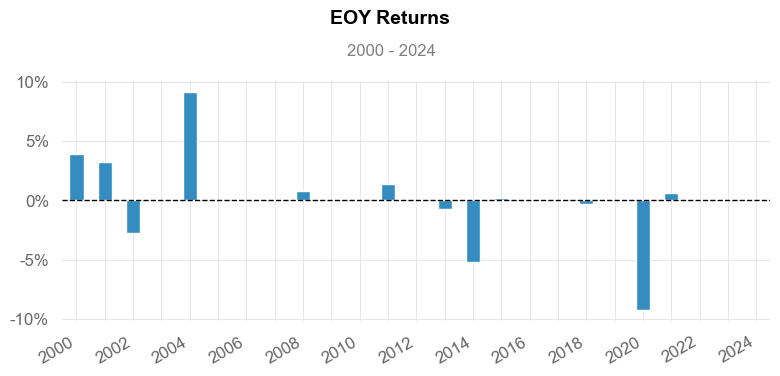

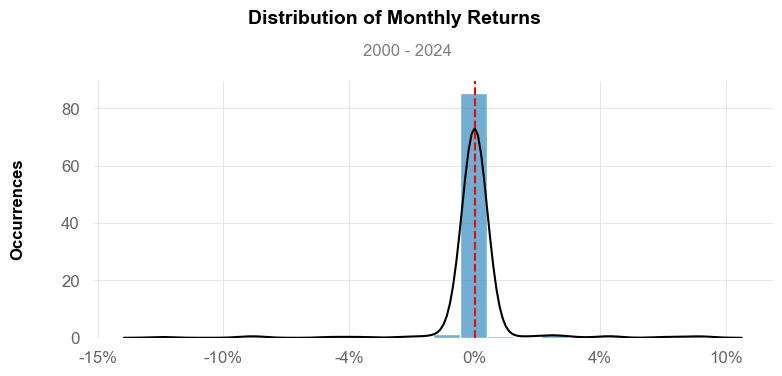

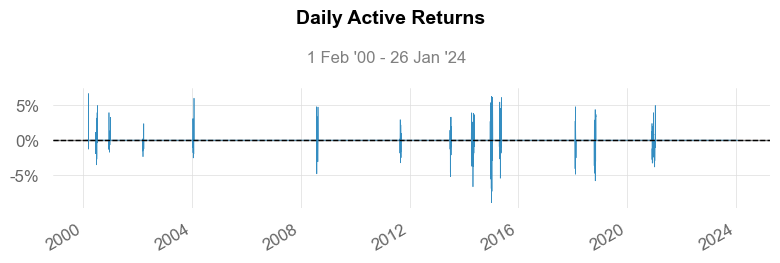

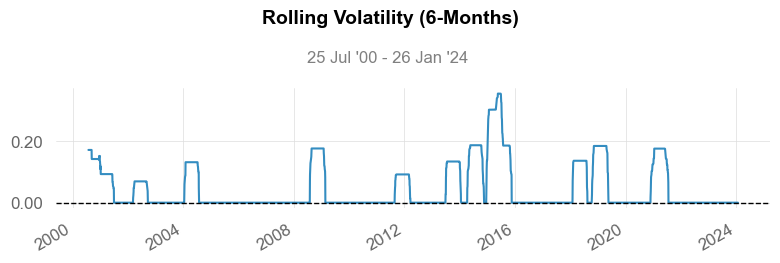

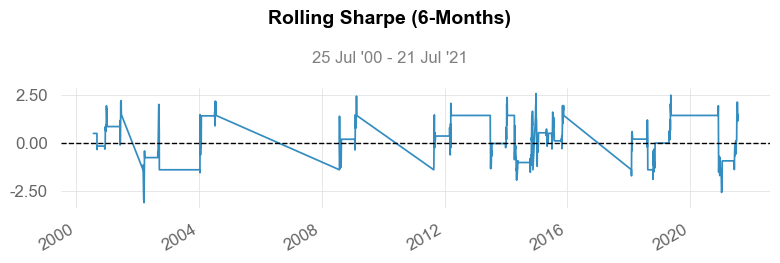

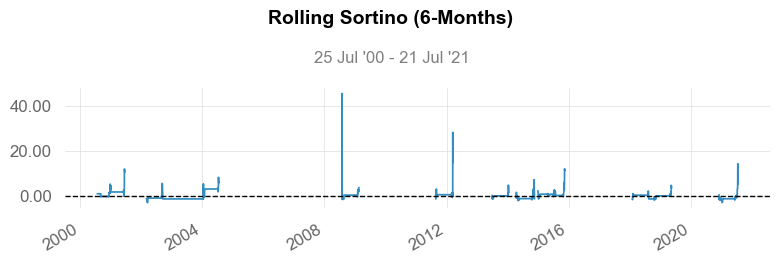

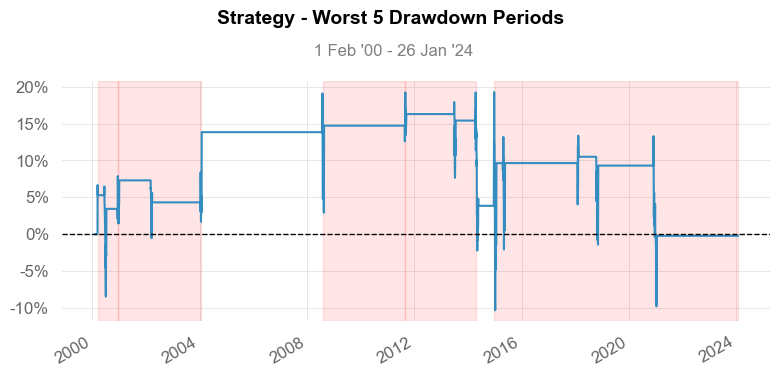

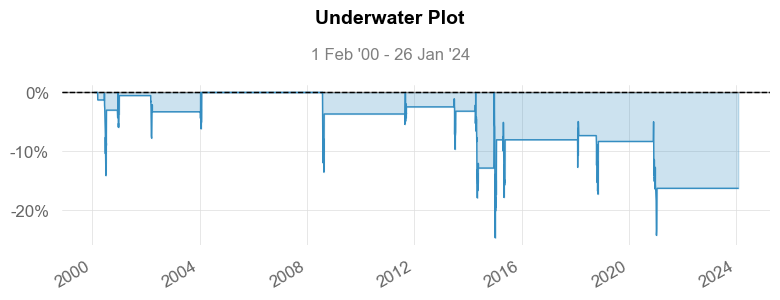

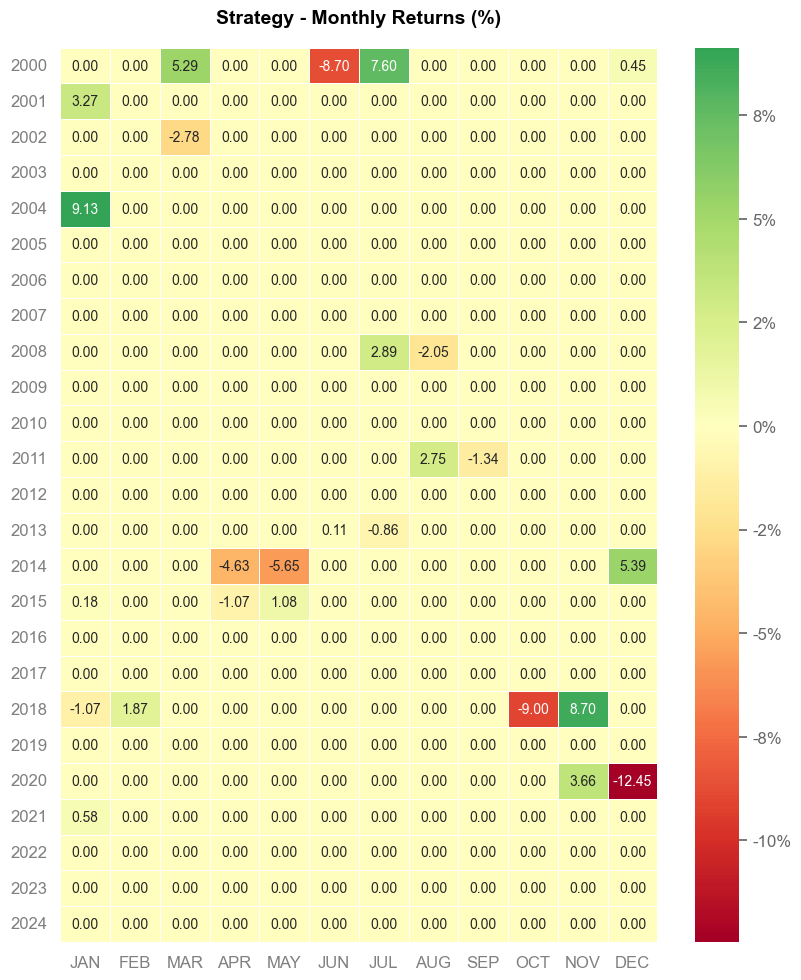

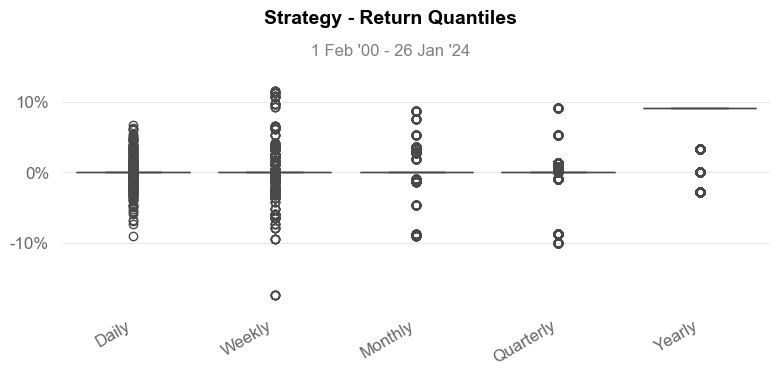

In [86]:
import warnings
# Suppress FutureWarning messages
warnings.simplefilter(action='ignore', category=FutureWarning)

qs.reports.full(data['strategy_returns'])

In [77]:
data[['retrn','strategy_returns']]

retrn  strategy_returns
Date                                  
2000-01-31       NaN               NaN
2000-02-01  0.019222               0.0
2000-02-02  0.019048               0.0
2000-02-03  0.027909               0.0
2000-02-04  0.025006               0.0
...              ...               ...
2024-01-22  0.004520               0.0
2024-01-23  0.012390               0.0
2024-01-24 -0.007627              -0.0
2024-01-25  0.036292               0.0
2024-01-26  0.017163               0.0

[6025 rows x 2 columns]